# Setup

In [1]:
import pandas as pd
import numpy as np
from sde_signals import par
from scipy.stats import norm, shapiro
import matplotlib.pyplot as plt

# SDE Correctness

In [2]:
sdedf = pd.read_csv('sde_data/theta_data.csv').set_index(['Seed'])
sdedf

,Theta,Inf,Alpha
Seed,,,
2001,0.0,10.4822,99.6003
2001,0.5,10.4827,99.0996
2001,1.0,10.4831,98.6039
2002,0.0,10.5837,99.2751
2002,0.5,10.5842,98.7750
...,...,...,...
7999,0.5,10.3855,100.2340
7999,1.0,10.3854,99.7314
8000,0.0,10.2859,100.6530


In [3]:
par.α

-100.0

In [4]:
mean, std = norm.fit(sdedf[sdedf.Theta==0.]['Alpha'])
mean, std

(100.62479979999999, 1.5339972922466194)

In [5]:
assert np.isclose(mean, -par.α, atol=std, rtol=1e-20)

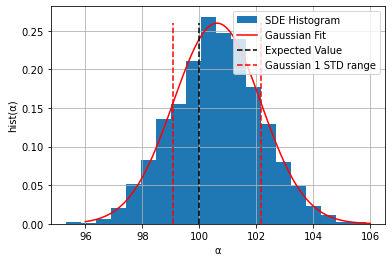

In [6]:
forward = sdedf[sdedf.Theta==0.]
forward['Alpha'].hist(bins=20, density=True, label='SDE Histogram')
plt.gca().set_xlabel('α')
plt.gca().set_ylabel('hist(α)')

sdemean, sdestd = norm.fit(forward['Alpha'])
x = np.linspace(96, 106, num=100)
y = norm.pdf(x, loc=sdemean, scale=sdestd)
mx = max(y)
plt.plot(x, y, 'r', label='Gaussian Fit')
plt.plot([100, 100], [0, mx], '--k', label='Expected Value')
plt.plot([sdemean-sdestd, sdemean-sdestd], [0, mx], '--r', label='Gaussian 1 STD range')
plt.plot([sdemean+sdestd, sdemean+sdestd], [0, mx], '--r')
plt.legend()
plt.savefig('SDE_Histogram.jpg', dpi=600)
plt.savefig('SDE_Histogram.svg', dpi=600)

In [7]:
sdemean, sdestd = norm.fit(forward.Alpha)
testval = norm(100, sdestd/np.sqrt(len(forward.Alpha.values)-1))
2*(1. - testval.cdf(sdemean)), forward.Alpha.std()/np.sqrt(len(forward.Alpha.values)), forward.Alpha.mean()

(0.0, 0.03430980075027749, 100.62479979999999)

Soemthing is a little off. We would expect α to be replicated around its expected value, and this feels wrong.
We should use a statistical test to verify if this shift could be explained, but I highly doubt that. I feel like there is a very small and stupid bug in my code.

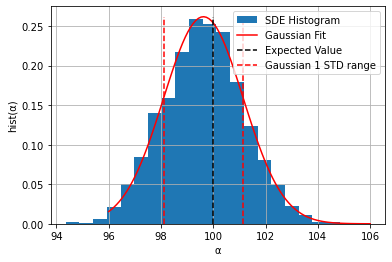

In [8]:
backward = sdedf[sdedf.Theta==1.]
backward['Alpha'].hist(bins=20, density=True, label='SDE Histogram')
plt.gca().set_xlabel('α')
plt.gca().set_ylabel('hist(α)')

sdemean, sdestd = norm.fit(backward['Alpha'])
x = np.linspace(96, 106, num=100)
y = norm.pdf(x, loc=sdemean, scale=sdestd)
mx = max(y)
plt.plot(x, y, 'r', label='Gaussian Fit')
plt.plot([100, 100], [0, mx], '--k', label='Expected Value')
plt.plot([sdemean-sdestd, sdemean-sdestd], [0, mx], '--r', label='Gaussian 1 STD range')
plt.plot([sdemean+sdestd, sdemean+sdestd], [0, mx], '--r')
plt.legend()
plt.savefig('SDE_Histogram_backward.jpg', dpi=600)
plt.savefig('SDE_Histogram_backward.svg', dpi=600)

In [9]:
sdemean, sdestd = norm.fit(backward.Alpha)
testval = norm(100, sdestd/np.sqrt(len(backward.Alpha.values)-1))
2*testval.cdf(sdemean), backward.Alpha.std()/np.sqrt(len(backward.Alpha.values)), backward.Alpha.mean()

(1.859321164840012e-28, 0.03406936000236068, 99.62303025)

This is still a little bit off, but less so. Therefore the numerical method does matter and it does change the result. That's important to note.

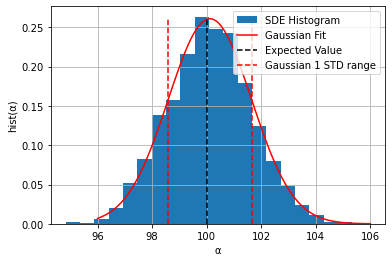

In [10]:
crank = sdedf[sdedf.Theta==0.5]
crank['Alpha'].hist(bins=20, density=True, label='SDE Histogram')
plt.gca().set_xlabel('α')
plt.gca().set_ylabel('hist(α)')

sdemean, sdestd = norm.fit(crank['Alpha'])
x = np.linspace(96, 106, num=100)
y = norm.pdf(x, loc=sdemean, scale=sdestd)
mx = max(y)
plt.plot(x, y, 'r', label='Gaussian Fit')
plt.plot([100, 100], [0, mx], '--k', label='Expected Value')
plt.plot([sdemean-sdestd, sdemean-sdestd], [0, mx], '--r', label='Gaussian 1 STD range')
plt.plot([sdemean+sdestd, sdemean+sdestd], [0, mx], '--r')
plt.legend()
plt.savefig('SDE_Histogram_crank.jpg', dpi=600)
plt.savefig('SDE_Histogram_crank.svg', dpi=600)

The Crank-Nickolson seems right on the money. OK. I think we got this.

In [11]:
shapiro(crank.Alpha)

ShapiroResult(statistic=0.9993764758110046, pvalue=0.7786957621574402)

As expected this is kind of a normal distribution.

In [12]:
sdemean, sdestd = norm.fit(crank['Alpha'])
testval = norm(100, sdestd/np.sqrt(len(crank.Alpha.values)-1))
2*(1. - testval.cdf(sdemean)), crank.Alpha.std()/np.sqrt(len(crank.Alpha.values)), crank.Alpha.mean()

(0.0003834239500566383, 0.034188953249717234, 100.12141310000001)

# Analog

In [13]:
analogdf = pd.read_csv('analog_data.csv').set_index('Seed')
analogdf

,Inf,Alpha
Seed,,
1,10.3139,100.6600
10,10.6894,98.1019
100,10.5791,100.3220
1000,10.4034,100.2430
101,10.4815,100.0810
...,...,...
995,10.4780,98.0817
996,10.4712,99.5976
997,10.5194,100.5660


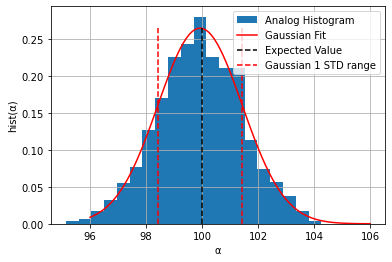

In [14]:
analogdf['Alpha'].hist(bins=20, density=True, label='Analog Histogram')
plt.gca().set_xlabel('α')
plt.gca().set_ylabel('hist(α)')

analogmean, analogstd = norm.fit(analogdf['Alpha'])
x = np.linspace(96, 106, num=100)
y = norm.pdf(x, loc=analogmean, scale=analogstd)
mx = max(y)
plt.plot(x, y, 'r', label='Gaussian Fit')
plt.plot([100, 100], [0, mx], '--k', label='Expected Value')
plt.plot([analogmean-analogstd, analogmean-analogstd], [0, mx], '--r', label='Gaussian 1 STD range')
plt.plot([analogmean+analogstd, analogmean+analogstd], [0, mx], '--r')
plt.legend()
plt.savefig('Analog_Histogram.jpg', dpi=600)
plt.savefig('Analog_Histogram.svg', dpi=600)

Now this is how we expected the model to behave!

In [15]:
mean, std = norm.fit(analogdf['Alpha'])
mean, std, shapiro(analogdf.Alpha)

(99.92867,
 1.504638732354049,
 ShapiroResult(statistic=0.9988510608673096, pvalue=0.7874799966812134))

In [16]:
testval = norm(100., analogdf.Alpha.std()/np.sqrt(len(analogdf.Alpha.values)))
testval.cdf(analogdf.Alpha.mean()), analogdf.Alpha.std()/np.sqrt(len(analogdf.Alpha.values)), analogdf.Alpha.mean() - 100

(0.06701693287687802, 0.047604662784424996, -0.07133000000000322)

In [17]:
assert np.isclose(mean, -par.α, atol=std, rtol=1e-20)

# Analog Timing

In [18]:
timedf = pd.read_csv('analog_timing_data.csv')
timedf

,Reactivity,Lifetime,Source,Detection Rate,Measurement Time,Seed,Runtime,Inf,Alpha
0,-0.01,0.00006,166810.1,0.000001,60.0,0,150.45,0.821737,1.339250
1,-0.01,0.00006,166810.1,0.000001,60.0,1,147.87,0.138980,72.961800
2,-0.01,0.00006,166810.1,0.000001,60.0,10,156.83,0.023257,105.912000
3,-0.01,0.00006,166810.1,0.000001,60.0,11,152.63,0.012874,1744.450000
4,-0.01,0.00006,166810.1,0.000001,60.0,12,152.45,0.163551,-0.000951
...,...,...,...,...,...,...,...,...,...
2495,-0.01,0.00006,166810.1,0.000167,60.0,5,190.92,4.619970,155.468000
2496,-0.01,0.00006,166810.1,0.000167,60.0,6,186.33,4.300520,158.704000
2497,-0.01,0.00006,166810.1,0.000167,60.0,7,182.81,4.570540,159.492000
2498,-0.01,0.00006,166810.1,0.000167,60.0,8,191.54,4.684980,165.251000


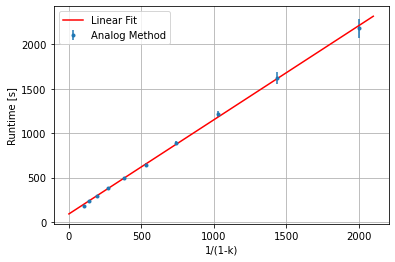

In [19]:
rhoindex = ['Lifetime', 'Source', 'Detection Rate', 'Measurement Time', 'Reactivity']
dat = (timedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Source'] == 1.668101e+05)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Measurement Time'] == 60.), :]
       .drop(columns=['Seed']).groupby(rhoindex).mean().reset_index()
       .assign(k=lambda x: 1/(1-x.Reactivity)).assign(**{'1/(1-k)': lambda y: 1/(1-y.k)}))
stdr = (timedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Source'] == 1.668101e+05)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Measurement Time'] == 60.), :]
        .drop(columns=['Seed']).groupby(rhoindex).std().reset_index())
dat = dat.assign(druntime=stdr['Runtime'])

v = np.polyfit(x=dat['1/(1-k)'].values, y=dat['Runtime'].values, deg=1)
plt.errorbar(dat['1/(1-k)'].values, dat['Runtime'].values, yerr=dat['druntime'], fmt='.', label='Analog Method')
plt.grid()
plt.xlabel('1/(1-k)')
plt.ylabel('Runtime [s]')
fx = np.linspace(0, 2100, num=100)
fy = v[1] + v[0]*fx
plt.plot(fx, fy, 'r', label='Linear Fit')
plt.legend()
plt.savefig('Analog_Reactivity_Runtime.jpg', dpi=600)

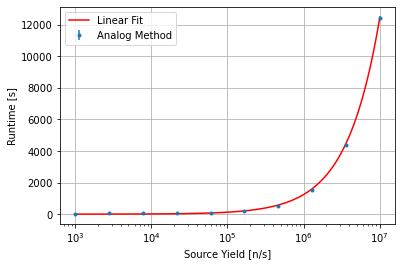

In [20]:
rhoindex = ['Lifetime', 'Source', 'Detection Rate', 'Measurement Time', 'Reactivity']
dat = (timedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Reactivity'] == -0.01)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Measurement Time'] == 60.), :]
       .drop(columns=['Seed']).groupby(rhoindex).mean().reset_index())
stdr = (timedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Reactivity'] == -0.01)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Measurement Time'] == 60.), :]
        .drop(columns=['Seed']).groupby(rhoindex).std().reset_index())
dat = dat.assign(druntime=stdr['Runtime'])

v = np.polyfit(x=dat['Source'].values, y=dat['Runtime'].values, deg=1)
plt.errorbar(dat['Source'].values, dat['Runtime'].values, yerr=dat['druntime'], fmt='.', label='Analog Method')
plt.gca().set_xscale('log')
plt.grid()
plt.xlabel('Source Yield [n/s]')
plt.ylabel('Runtime [s]')
fx = np.logspace(3, 7, num=100)
fy = v[1] + v[0]*fx
plt.plot(fx, fy, 'r', label='Linear Fit')
plt.legend()
plt.savefig('Analog_Source_Runtime.jpg', dpi=600)

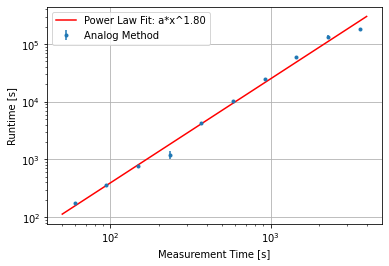

In [21]:
rhoindex = ['Lifetime', 'Source', 'Detection Rate', 'Measurement Time', 'Reactivity']
dat = (timedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Reactivity'] == -0.01)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Source'] == 1.668101e+05), :]
       .drop(columns=['Seed']).groupby(rhoindex).mean().reset_index())
stdr = (timedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Reactivity'] == -0.01)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Source'] == 1.668101e+05), :]
        .drop(columns=['Seed']).groupby(rhoindex).std().reset_index())
dat = dat.assign(druntime=stdr['Runtime'])

v = np.polyfit(x=np.log(dat['Measurement Time'].values), y=np.log(dat['Runtime'].values), deg=1)
plt.errorbar(dat['Measurement Time'].values, dat['Runtime'].values, yerr=dat['druntime'], fmt='.', label='Analog Method')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.grid()
plt.xlabel('Measurement Time [s]')
plt.ylabel('Runtime [s]')
fx = np.logspace(1.7, 3.6, num=100)
fy = np.exp(v[1])*(fx**v[0])
plt.plot(fx, fy, 'r', label=f'Power Law Fit: a*x^{v[0]:.2f}')
plt.legend()
plt.savefig('Analog_Measurement_Runtime.jpg')

# SDE Timing

In [22]:
sdetimedf = pd.read_csv('sde_timing_data.csv')
sdetimedf

,Reactivity,Lifetime,Source,Detection Rate,Measurement Time,Seed,Runtime,Inf,Alpha
0,-0.01,0.00006,166810.1,0.000001,60.0,0,0.76427,-0.043413,4.328070e-02
1,-0.01,0.00006,166810.1,0.000001,60.0,1,0.80481,2.457910,1.319140e+00
2,-0.01,0.00006,166810.1,0.000001,60.0,10,0.87147,0.050798,1.271340e+05
3,-0.01,0.00006,166810.1,0.000001,60.0,11,0.73257,-0.047773,9.385140e+11
4,-0.01,0.00006,166810.1,0.000001,60.0,12,0.81989,0.414449,1.242360e+00
...,...,...,...,...,...,...,...,...,...
2491,-0.01,0.00006,166810.1,0.000167,60.0,5,0.72492,4.268690,1.748520e+02
2492,-0.01,0.00006,166810.1,0.000167,60.0,6,0.71770,4.498570,1.547770e+02
2493,-0.01,0.00006,166810.1,0.000167,60.0,7,0.72296,4.536450,1.593370e+02
2494,-0.01,0.00006,166810.1,0.000167,60.0,8,0.70648,4.544860,1.666230e+02


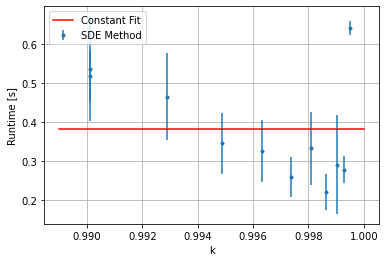

In [23]:
rhoindex = ['Lifetime', 'Source', 'Detection Rate', 'Measurement Time', 'Reactivity']
dat = (sdetimedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Source'] == 1.668101e+05)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Measurement Time'] == 60.), :]
       .drop(columns=['Seed']).groupby(rhoindex).mean().reset_index()
       .assign(k=lambda x: 1/(1-x.Reactivity)))
stdr = (sdetimedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Source'] == 1.668101e+05)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Measurement Time'] == 60.), :]
        .drop(columns=['Seed']).groupby(rhoindex).std().reset_index())
dat = dat.assign(druntime=stdr['Runtime'])

v = np.polyfit(x=dat['k'].values, y=dat['Runtime'].values, deg=0)
plt.errorbar(dat['k'].values, dat['Runtime'].values, yerr=dat['druntime'], fmt='.', label='SDE Method')
plt.grid()
plt.xlabel('k')
plt.ylabel('Runtime [s]')
fx = np.linspace(0.989, 1, num=100)
fy = v[0]*np.ones_like(fx)
plt.plot(fx, fy, 'r', label='Constant Fit')
plt.legend()
plt.savefig('SDE_Reactivity_Runtime.jpg', dpi=600)

In [24]:
dat.Runtime.max()

0.6410106521739131

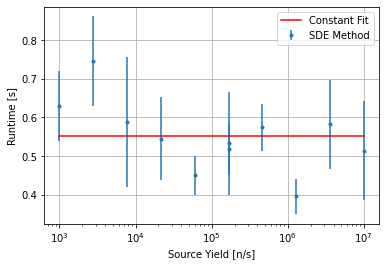

In [25]:
rhoindex = ['Lifetime', 'Source', 'Detection Rate', 'Measurement Time', 'Reactivity']
dat = (sdetimedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Reactivity'] == -0.01)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Measurement Time'] == 60.), :]
       .drop(columns=['Seed']).groupby(rhoindex).mean().reset_index())
stdr = (sdetimedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Reactivity'] == -0.01)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Measurement Time'] == 60.), :]
        .drop(columns=['Seed']).groupby(rhoindex).std().reset_index())
dat = dat.assign(druntime=stdr['Runtime'])

v = np.polyfit(x=dat['Source'].values, y=dat['Runtime'].values, deg=0)
plt.errorbar(dat['Source'].values, dat['Runtime'].values, yerr=dat['druntime'], fmt='.', label='SDE Method')
plt.gca().set_xscale('log')
plt.grid()
plt.xlabel('Source Yield [n/s]')
plt.ylabel('Runtime [s]')
fx = np.logspace(3, 7, num=100)
fy = v[0]*np.ones_like(fx)
plt.plot(fx, fy, 'r', label='Constant Fit')
plt.legend()
plt.savefig('SDE_Source_Runtime.jpg', dpi=600)

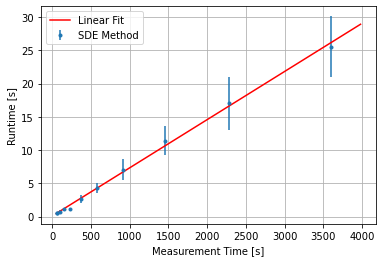

In [26]:
rhoindex = ['Lifetime', 'Source', 'Detection Rate', 'Measurement Time', 'Reactivity']
dat = (sdetimedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Reactivity'] == -0.01)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Source'] == 1.668101e+05), :]
       .drop(columns=['Seed']).groupby(rhoindex).mean().reset_index())
stdr = (sdetimedf.loc[(5.99e-5 < timedf['Lifetime']) 
                   & (timedf['Lifetime'] < 6.01e-5) 
                   & (timedf['Reactivity'] == -0.01)
                   & (timedf['Detection Rate'] > 0.000166) 
                   & (timedf['Detection Rate'] < 0.000168)
                   & (timedf['Source'] == 1.668101e+05), :]
        .drop(columns=['Seed']).groupby(rhoindex).std().reset_index())
dat = dat.assign(druntime=stdr['Runtime'])

v = np.polyfit(x=dat['Measurement Time'].values, y=dat['Runtime'].values, deg=1)
plt.errorbar(dat['Measurement Time'].values, dat['Runtime'].values, yerr=dat['druntime'], fmt='.', label='SDE Method')
plt.grid()
plt.xlabel('Measurement Time [s]')
plt.ylabel('Runtime [s]')
fx = np.logspace(1.7, 3.6, num=100)
fy = v[1]+ (fx*v[0])
plt.plot(fx, fy, 'r', label=f'Linear Fit')
plt.legend()
plt.savefig('SDE_Measurement_Runtime.jpg')

In [27]:
dat.Runtime.max()

25.571019999999997

# Speedup

In [28]:
sdemeandf = sdetimedf.groupby(rhoindex).mean().reset_index()
sdemeandf['SDE RuntimeSTD'] = sdetimedf.groupby(rhoindex).std().reset_index()['Runtime']
sdemeandf.drop(columns=['Seed'], inplace=True)
sdemeandf.rename(columns = {'Runtime': 'SDE Runtime', 'Inf': 'SDE YInf', 'Alpha': 'SDE Alpha Mean'}, inplace=True)

In [29]:
analogmeandf =  timedf.groupby(rhoindex).mean().reset_index()
analogmeandf['Analog RuntimeSTD'] = timedf.groupby(rhoindex).std().reset_index()['Runtime']
analogmeandf.drop(columns=['Seed'], inplace=True)
analogmeandf.rename(columns = {'Runtime': 'Analog Runtime', 'Inf': 'Analog Yinf', 'Alpha': 'Analog Alpha Mean'}, inplace=True)

In [30]:
combined = (pd.concat([analogmeandf.groupby(rhoindex).mean(), 
                       sdemeandf.groupby(rhoindex).mean()], 
                      axis=1)
            .reset_index()
            .assign(speedup=lambda x: x['Analog Runtime']/x['SDE Runtime']))
filtered = (combined.drop(columns=set(combined.columns) - (set(rhoindex) | {'speedup'}))
            .groupby(['Source', 'Measurement Time', 'Reactivity'])
            .mean().reset_index().drop(columns=['Lifetime', 'Detection Rate']))
filtered

,Source,Measurement Time,Reactivity,speedup
0,1.000000e+03,60.00000,-0.010000,42.065348
1,2.782559e+03,60.00000,-0.010000,57.888087
2,7.742637e+03,60.00000,-0.010000,76.296521
3,2.154435e+04,60.00000,-0.010000,105.104669
4,5.994843e+04,60.00000,-0.010000,187.230342
5,1.668101e+05,60.00000,-0.010000,273.912160
6,1.668101e+05,60.00000,-0.007169,493.709343
7,1.668101e+05,60.00000,-0.005139,847.111693
8,1.668101e+05,60.00000,-0.003684,1184.322548
9,1.668101e+05,60.00000,-0.002641,1904.617375


In [31]:
filtered.speedup.min(), filtered.speedup.max()

(42.06534759721429, 24191.146614177702)

# $\alpha$ Deviation Analysis

In [1]:
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
from uncertainties import ufloat

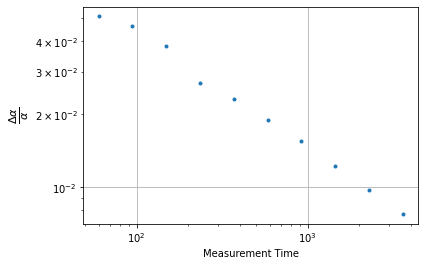

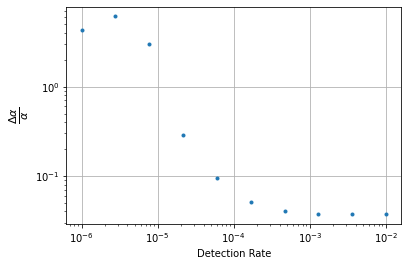

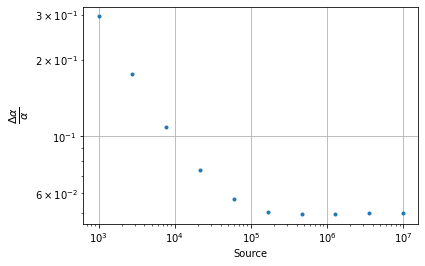

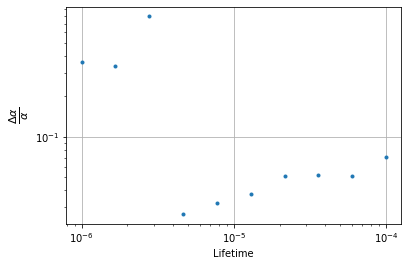

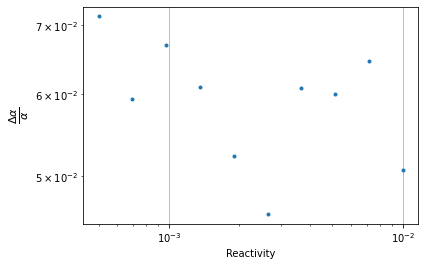

In [33]:
sdestddf = pd.read_csv('sde_timing_data.csv')
keys = ['Reactivity', 'Lifetime', 'Source', 'Detection Rate', 'Measurement Time']
grpd = sdestddf.groupby(keys)
stddata = grpd.std()['Alpha']
stddata.name = 'Alpha STD'
meandata = grpd.mean()['Alpha']
newdata = pd.concat([meandata, stddata], axis=1)
defaults = {key: newdata.reset_index()[key].mode()[0] for key in keys}
levels = {key: i for i, key in enumerate(defaults.keys())}
options = list(map(dict, it.combinations(defaults.items(), len(defaults)-1)))
slices = list(map(lambda x: tuple({key: x.get(key, slice(None)) for key in keys}.values()), options))
val_names = ['Alpha', 'Alpha STD']
for option, slc in zip(options, slices):
    unkey = (set(defaults.keys()) - set(option.keys())).pop()
    dat = newdata.loc[slc].reset_index().loc[:, (unkey, *val_names)]
    x, y = dat[unkey], dat['Alpha STD'] / dat['Alpha']
    plt.figure()
    plt.loglog(abs(x), y, '.')
    plt.xlabel(unkey)
    plt.ylabel(r'$\frac{\Delta\alpha}{\alpha}$', fontsize=16)
    plt.grid()
    plt.show()

## Full data analysis

In [3]:
sdestddf = pd.read_csv('sde_std_fixed.csv').assign(
    AlphaCor=lambda x: [ufloat(*y) for y in zip(x.Alpha.values, np.sqrt(x.ConvAlphaAlpha))])
keys = ['Reactivity', 'Lifetime', 'Source', 'Detection Rate', 'Measurement Time']
grpd = sdestddf.groupby(keys)
stddata = grpd.Alpha.std()
stddata.name = 'Alpha STD'
meandata = grpd.AlphaCor.aggregate(lambda x: sum(x)/len(x))
meandata.name = 'Alpha'
newdata = pd.concat([meandata, stddata], axis=1)
defaults = {key: newdata.reset_index()[key].mode()[0] for key in keys}
levels = {key: i for i, key in enumerate(defaults.keys())}
options = list(map(dict, it.combinations(defaults.items(), len(defaults)-1)))
slices = list(map(lambda x: tuple({key: x.get(key, slice(None)) for key in keys}.values()), options))
val_names = ['Alpha', 'Alpha STD']

In [10]:
sdestddf

,Reactivity,Lifetime,Source,Detection Rate,Measurement Time,Seed,Inf,Alpha,CovInf,CovInfAlpha,CovAlphaInf,ConvAlphaAlpha,AlphaCor
0,-0.0005,0.00006,166810.1,0.000167,60.0,0,1580.73000,8.83991,44.434900,-0.277678,-0.277678,0.001743,8.84+/-0.04
1,-0.0005,0.00006,166810.1,0.000167,60.0,1,1762.81000,8.63753,34.871600,-0.190514,-0.190514,0.001045,8.638+/-0.032
2,-0.0005,0.00006,166810.1,0.000167,60.0,2,2900.93000,6.16167,2605.330000,-5.998850,-5.998850,0.013843,6.16+/-0.12
3,-0.0005,0.00006,166810.1,0.000167,60.0,3,1798.92000,8.20679,133.379000,-0.675258,-0.675258,0.003432,8.21+/-0.06
4,-0.0005,0.00006,166810.1,0.000167,60.0,4,1612.33000,8.79057,27.069000,-0.164827,-0.164827,0.001008,8.791+/-0.032
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50995,-0.0100,0.00006,166810.1,0.000167,3600.0,946,4.37960,168.41800,0.000029,-0.001592,-0.001592,0.110524,168.42+/-0.33
50996,-0.0100,0.00006,166810.1,0.000167,3600.0,947,4.40141,167.66700,0.000024,-0.001336,-0.001336,0.091793,167.67+/-0.30
50997,-0.0100,0.00006,166810.1,0.000167,3600.0,948,4.41501,166.03700,0.000059,-0.003198,-0.003198,0.216751,166.0+/-0.5
50998,-0.0100,0.00006,166810.1,0.000167,3600.0,949,4.32760,170.21900,0.000139,-0.007872,-0.007872,0.559387,170.2+/-0.7


In [52]:
np.array([0.13, 0.22, 0.2, 0.2, 0.1, 0.1, 0.05]) @ (np.arange(0,7)**2)

8.72

In [47]:
prob_case = sdestddf.mode()
prob_case.iloc[0]

Reactivity             -0.01
Lifetime             0.00006
Source              166810.1
Detection Rate      0.000167
Measurement Time        60.0
Seed                    50.0
Inf                      1.0
Alpha                165.031
CovInf                   inf
CovInfAlpha              inf
CovAlphaInf        -0.226583
ConvAlphaAlpha       3.85702
AlphaCor             -3+/-25
Name: 0, dtype: object

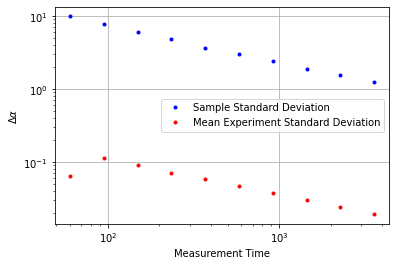

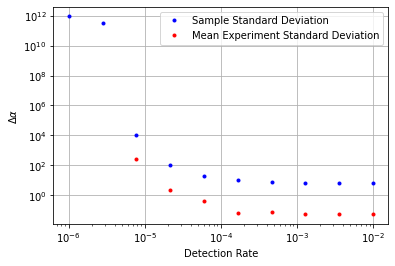

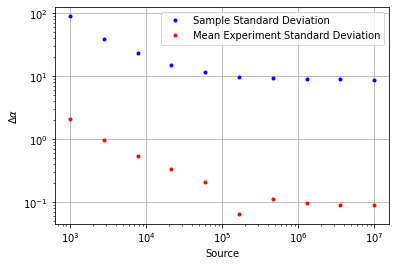

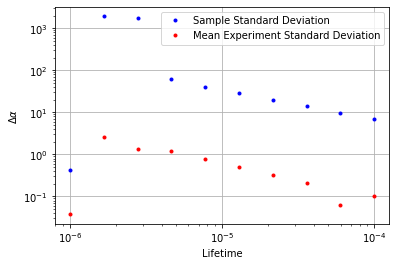

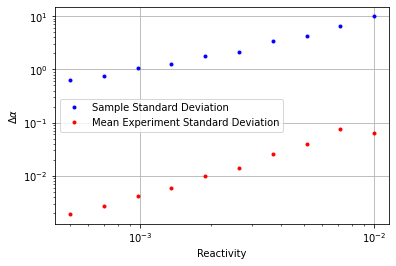

In [39]:
for option, slc in zip(options, slices):
    unkey = (set(defaults.keys()) - set(option.keys())).pop()
    dat = newdata.loc[slc].reset_index().loc[:, (unkey, *val_names)]
    x, stdy, erry = dat[unkey], dat['Alpha STD'], [z.s for z in dat['Alpha']]
    plt.figure()
    plt.loglog(abs(x), stdy, 'b.', label='Sample Standard Deviation')
    plt.loglog(abs(x), erry, 'r.', label='Mean Experiment Standard Deviation')
    plt.xlabel(unkey)
    plt.ylabel(r'$\Delta\alpha$')
    plt.grid()
    plt.legend()

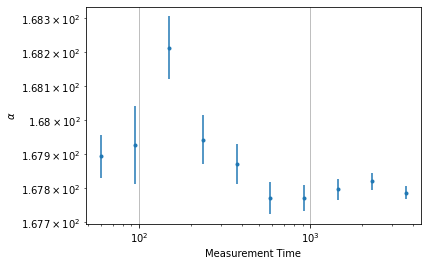

/home/esheder/miniconda3/envs/noise/lib/python3.9/site-packages/numpy/core/_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/esheder/miniconda3/envs/noise/lib/python3.9/site-packages/numpy/core/_methods.py:39: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


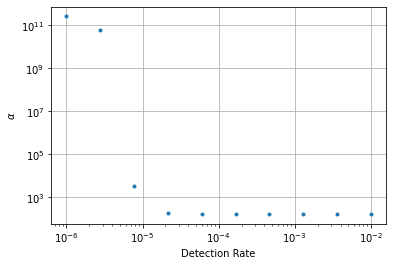

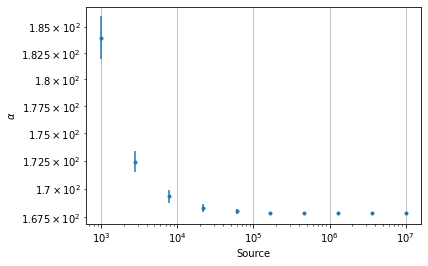

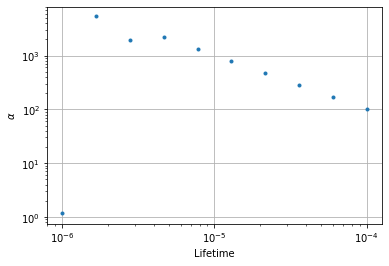

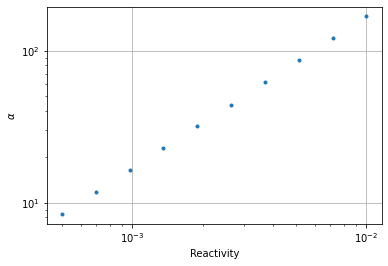

In [36]:
for option, slc in zip(options, slices):
    unkey = (set(defaults.keys()) - set(option.keys())).pop()
    dat = newdata.loc[slc].reset_index().loc[:, (unkey, *val_names)]
    x, stdy = dat[unkey], dat['Alpha']
    y, yerr = [z.n for z in stdy], [z.s for z in stdy]
    plt.figure()
    plt.errorbar(abs(x), y, yerr=yerr, fmt='.')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(unkey)
    plt.ylabel(r'$\alpha$')
    plt.grid()
    plt.show()

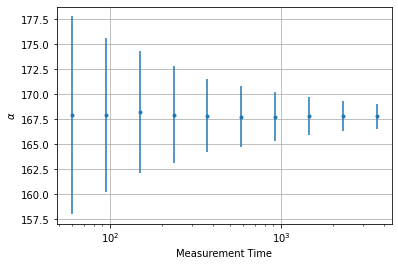

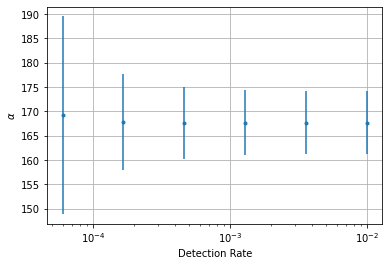

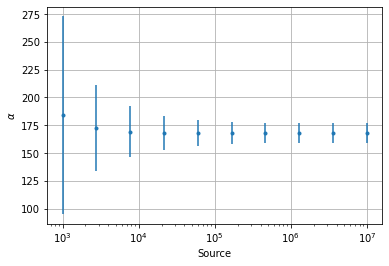

In [37]:
for option, slc in zip(options, slices):
    unkey = (set(defaults.keys()) - set(option.keys())).pop()
    if unkey in {'Lifetime', 'Reactivity'}:
        continue
    dat = newdata.loc[slc].reset_index().loc[:, (unkey, *val_names)]
    x, stdy, sampledy = dat[unkey], dat['Alpha'], dat['Alpha STD']
    y, yerr = np.array([z.n for z in stdy]), [z.s for z in stdy]
    mask = sampledy.values<0.5*y
    x, y, dy = x[mask], y[mask], sampledy[mask]
    plt.figure()
    plt.errorbar(abs(x), y, yerr=dy, fmt='.')
    plt.xscale('log')
    plt.xlabel(unkey)
    plt.ylabel(r'$\alpha$')
    plt.grid()
    plt.show()

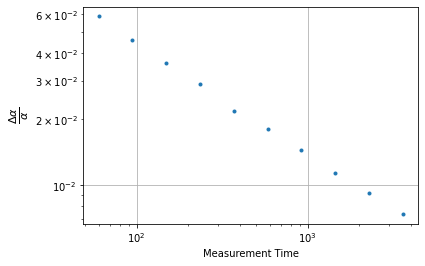

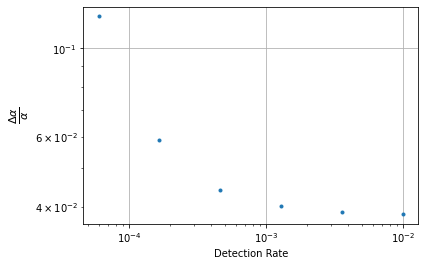

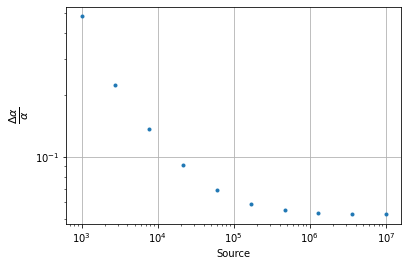

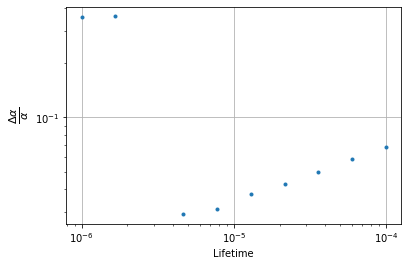

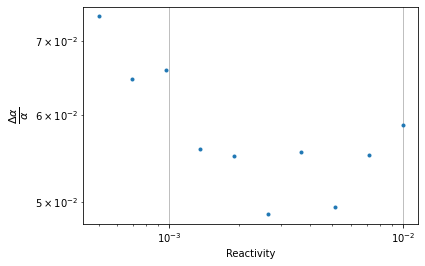

In [44]:
for option, slc in zip(options, slices):
    unkey = (set(defaults.keys()) - set(option.keys())).pop()
    dat = newdata.loc[slc].reset_index().loc[:, (unkey, *val_names)]
    x, stdy, sampledy = dat[unkey], dat['Alpha'], dat['Alpha STD']
    y, yerr = np.array([z.n for z in stdy]), [z.s for z in stdy]
    mask = sampledy.values<0.5*y
    x, y, dy = x[mask], y[mask], sampledy[mask]
    plt.figure()
    plt.loglog(abs(x), dy/y, '.')
    plt.xlabel(unkey)
    plt.ylabel(r'$\frac{\Delta\alpha}{\alpha}$', fontsize=16)
    plt.grid()
    plt.savefig(f"sde_std_{unkey.replace(' ','_')}.jpg", dpi=600)

## Per Reactivity Analysis

In [63]:
import operator
from functools import reduce

In [67]:
def condition(data, key, keys):
    return reduce(operator.and_, (data[okey] == defaults[okey] for okey in set(keys) - {key}))

def xypair(data, key, keys):
    subdata = data[:][condition(data, key, keys)]
    return subdata[key], subdata['Alpha STD'] / subdata.Alpha

def asymptote(x, y, threshold):
    yinf = y[x.argmax()]
    return x[np.abs((y-yinf)/yinf) < threshold].min()

In [68]:
sdestddf = pd.read_csv('sde_std_settings.csv').drop(columns=['Lifetime'])
keys = ['Reactivity', 'Source', 'Detection Rate', 'Measurement Time']
grpd = sdestddf.groupby(keys)
stddata = grpd.std()['Alpha']
stddata.name = 'Alpha STD'
meandata = grpd.mean()['Alpha']
defaults = {key: pd.concat([meandata, stddata], axis=1).reset_index()[key].mode()[0] 
            for key in set(keys) - {'Reactivity'}}
newdata = pd.concat([meandata, stddata], axis=1).reset_index()
reactivities = newdata.Reactivity.unique()
datadict = {reactivity: newdata[:][newdata.Reactivity == reactivity] for reactivity in reactivities}

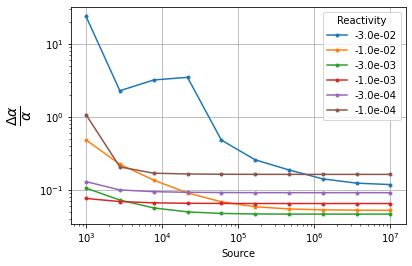

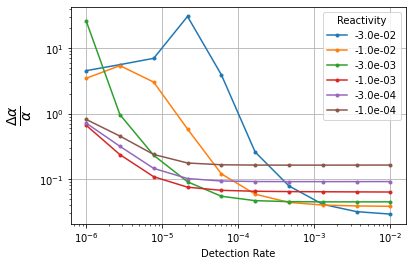

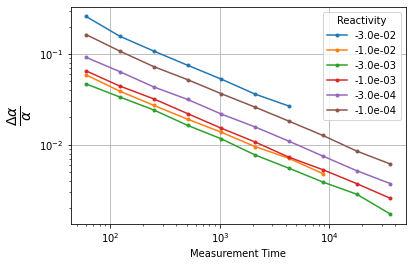

In [79]:
for key in defaults.keys():
    plt.figure()
    for reactivity, data in datadict.items():
        subdata = data[:][condition(data, key, defaults.keys())]
        x = subdata[key].values
        y = (subdata['Alpha STD'] / subdata['Alpha']).values
        plt.loglog(x, y, '.-', label=f'{reactivity:.1e}')
    plt.grid()
    plt.legend(title='Reactivity')
    plt.xlabel(f'{key}')
    plt.ylabel(r'$\frac{\Delta\alpha}{\alpha}$', fontsize=20)

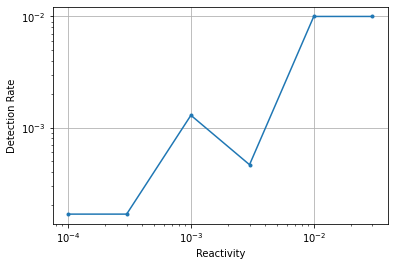

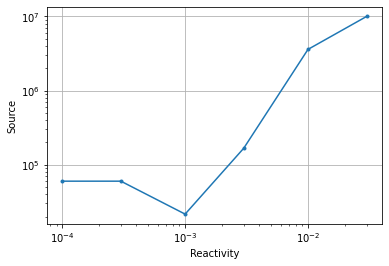

In [78]:
for key in ('Detection Rate', 'Source'):
    keydata = {r: asymptote(*map(lambda x: x.values, 
                                 xypair(data, key, defaults.keys())),
                           threshold=0.9e-2)
               for r, data in datadict.items()}
    rs, asyms = zip(*keydata.items())
    plt.figure()
    plt.loglog(np.abs(rs), asyms, '.-')
    plt.ylabel(key)
    plt.xlabel('Reactivity')
    plt.grid()